# Arabic Learner Corpus Considerations: Data Organization and Cleaning <a name="top"></a>
Anthony Verardi | a.verardi@pitt.edu | 2/24/2020 | University of Pittsburgh

The following notebook reads in textual data and metadata from the [Arabic Learner Corpus](https://www.arabiclearnercorpus.com/)(full citation below) for further exploration.

The process followed in this Notebook has been made possible by guidance from the following: 
* Dr. Jevon Heath, University of Pittsburgh
* [From XML to Pandas dataframes](https://medium.com/@robertopreste/from-xml-to-pandas-dataframes-9292980b1c1c) by Roberto Preste
* This very helpful [StackOverflow page on opening and parsing multiple XML files](https://stackoverflow.com/questions/45821807/open-and-parse-multiple-xml-files-from-a-folder)

Corpus credit to: Alfaifi, A., Atwell, E. and Hedaya, I. (2014). Arabic Learner Corpus (ALC) v2: A New Written and Spoken Corpus of Arabic Learners. In the proceedings of the Learner Corpus Studies in Asia and the World (LCSAW) 2014, 31 May - 01 Jun 2014. Kobe, Japan. http://www.arabiclearnercorpus.com.

**Table of Contents**
1. [Reading in the XML Files](#xml)
    1. [Importing with `BeautifulSoup`](#BS4)
    1. [Basic Stats](#DES)
1. [Exploratory Data Analysis and Cleaning](#EDACleaning)
    1. [Visualizing Text Counts by Nativeness and L1](#visualizing1)
    1. [Filling in "NaN" Values in Titles](#NaN)
    1. [Tokenizing Texts and Titles](#TOK)
    1. [Adding TTR](#TTR)
    1. [Collapsing L1 Data Into L1 Families](#L1FAM)

## Section 1: Reading in the XML Files <a name="xml"></a>
In this section, we'll just work on setting up our work environment with the packages we need and reading in our data from the XML files that it comes in.

In [1]:
# Importing necessary packages to begin reading in our data. The files come in XML format,
# so we'll need to import a library, BeautifulSoup, that can read them in and get the data
# ready for input into a DataFrame. Glob is for easily working with batches of files at once.

import nltk, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

# Allowing for multiple lines of output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# For toggling pretty printing off/on
%pprint

Pretty printing has been turned OFF


In [3]:
# Setting up our corpus directory
corDir = '../../Arabic-Learner-Corpus-Considerations/data/'

In [4]:
# Globbing essays together
essay_fnames = glob.glob(corDir+'*.xml')

The first thing to do is take the data we have from the XML format it comes in and read it in using the `BeautifulSoup` package. This will allow us to easily maintain the structure and metadata that accompanies the text. Then we'll put our data into an easily-readible and manipulable `DataFrame` using `pandas`. The following variables will be pulled from the XML data:
* DocID (the name of the original response document, to be used as an index value later)
* L1 (renamed from "Mothertongue" in the original markup; comprised of 66 L1s total)
* NumLangs (number of languages known by the participant, ranging from 1-10)
* Nationality
* Age
* Gender
* Nativeness (native Arabic speaker or non-native Arabic speaker)
* YearsStudy (years studying Modern Standard Arabic)
* GenLvl (whether a participant's academic career was pre-university or university)
* LvlStdy (Secondary school, language course, diploma course, BA, or MA)
* Title (of the response)
* Text (of the response)
* Genre (narrative or discussion)
* Mode (written or spoken)
* *Note: while "Length" was available as a tag for import, I have chosen to calculate the length myself for this project using NLTK's built-in tokenizer*

### 1A. Importing with `BeautifulSoup` <a name="BS4"></a>

In [5]:
# Setting up empty lists for my "row" info and setting names for the columns
# The "rows" will be populated with data from our XML files
df_rows = []

# The order of these items will be their order in our resulting DataFrame, so it makes
# sense to organize them now and save a step later reorganizing them
df_cols = ["DocID", "Nativeness", "L1",  "NumLangs", "Nationality", "Age", 
           "Gender", "YearsStudy", "GenLvl", "LvlStdy",
           "Title", "Text", "Genre", "Mode"]

# Making a Beautiful Soup from the globbed files. The process works by looping through each file and making a 
# "soup" out of its individual content, then appending the parts of that "soup", i.e. the tags, into our df_rows
# list that we set up before. This actually results in a list of dictionaries that Pandas can later parse into a 
# DataFrame for us

for file in essay_fnames:
    with open(file, 'r', encoding = 'UTF-16') as response:
        soup = BeautifulSoup(response, "lxml")
        for tag in soup:
            # l = learner, t = text; grouped by learner info and text info 
            l_docID = soup.doc['id'] # This will return the document ID, which is an ATTRIBUTE of the tag 'doc'
            l_nationality = soup.nationality.string # Using .string returns all of the string text
            l_age = soup.age.string                 # alone without brackets around the sides 
            l_gender = soup.gender.string
            l_YearsStudy = int(soup.no_years_learning_arabic.string)
            l_nativeness = soup.nativeness.string
            l_L1 = soup.mothertongue.string
            l_numLangs = int(soup.no_languages_spoken.string)
            l_GenLvl = soup.general_level.string
            l_LvlStdy = soup.level_study.string
            
            t_title = soup.title.string
            t_text = soup.text_body.string
            t_genre = soup.genre.string
            t_mode = soup.mode.string
        
        df_rows.append({"DocID":l_docID, "Nationality":l_nationality, 
                        "Age":l_age, "Gender":l_gender,
                        "Nativeness":l_nativeness,"L1":l_L1, "NumLangs":l_numLangs,
                        "YearsStudy":l_YearsStudy, "GenLvl":l_GenLvl,
                        "LvlStdy":l_LvlStdy, "Title":t_title, 
                        "Text":t_text, "Genre":t_genre,
                        "Mode":t_mode})

# Creating a DataFrame
df = pd.DataFrame(df_rows, columns = df_cols)

# Setting the DocID column as the index
df.set_index(['DocID'], inplace=True)

# Printing out a snapshot of the DataFrame to examine
df.head()

,Nativeness,L1,NumLangs,Nationality,Age,Gender,YearsStudy,GenLvl,LvlStdy,Title,Text,Genre,Mode
DocID,,,,,,,,,,,,,
S001_T1_M_Pre_NNAS_W_C,NNAS,Moore,4,Burkina Faso,20,Male,14,Pre-university,Diploma course,الرحلة إلى القرية لزيارة ذوي القربى,اعتدت الذهاب إلى قريتي في الإجازات الصيفيّة ال...,Narrative,Written
S001_T2_M_Pre_NNAS_W_C,NNAS,Moore,4,Burkina Faso,20,Male,14,Pre-university,Diploma course,الجمع بين العلم الشرعي والعلوم الدنيوية لحمزة ...,أحبّ أن ألتحق بكلِّية الشريعة بعد الانتها من ا...,Discussion,Written
S002_T1_M_Pre_NNAS_W_C,NNAS,Russian,5,Russian,25,Male,5,Pre-university,Diploma course,رحلة الحج المباركة,كتب الله لي أن أحج إلى بيته الحرام السنة الماض...,Narrative,Written
S002_T2_M_Pre_NNAS_W_C,NNAS,Russian,5,Russian,25,Male,5,Pre-university,Diploma course,أكثر من التخصص,الحمد لله الذي وفقني لدراسة شرعية في جامعة الإ...,Discussion,Written
S003_T1_M_Pre_NNAS_W_C,NNAS,Tatar,4,Russian,24,Male,6,Pre-university,Diploma course,رحلتي إلى الجبال,في أحد الأيام الصيف أخبرنا أبي بسفرٍ إلى الغاب...,Narrative,Written


~Right now, I can only get `BeautifulSoup` to read in the very first line of the test XML file. I followed a brief tutorial that used a toy XML file and it parsed that just fine, so I'm not sure what the issue is here. I created a `TEST.xml` file based on the first item in the actual corpus to play with, but no deletion fixed the parsing issue. I need to sort this out in order to move forward, but so far, nothing's come up helpful.~

~The goal right now is to get the XML data loaded into a `DataFrame` object in `pandas` so that I can do some statistical analyses on the learner samples. At the very least, let's try to get an idea of how many files we're working with here. We'll switch over to using the full dataset for this, the one we assigned `corDirFull` to earlier.~ 

Time and helpful guidance fix all things! As can be seen above, our `DataFrame` has been successfully populated with our data. Before we go any further with adding our own information, let's look at some basic statistics for this dataset.

### 1B. Basic Stats <a name="DES"></a>

In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1585 entries, S001_T1_M_Pre_NNAS_W_C to S942_T1_M_Uni_NAS_S_C
Data columns (total 13 columns):
Nativeness     1585 non-null object
L1             1585 non-null object
NumLangs       1585 non-null int64
Nationality    1585 non-null object
Age            1585 non-null object
Gender         1585 non-null object
YearsStudy     1585 non-null int64
GenLvl         1585 non-null object
LvlStdy        1585 non-null object
Title          1366 non-null object
Text           1585 non-null object
Genre          1585 non-null object
Mode           1585 non-null object
dtypes: int64(2), object(11)
memory usage: 173.4+ KB


,NumLangs,YearsStudy
count,1585.000000,1585.000000
mean,2.344479,2.400631
std,1.269274,3.702528
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,3.000000,3.000000
max,10.000000,19.000000


[Back to Top](#top)

## Section 2: Exploratory Data Analysis and Cleaning <a name="EDACleaning"></a>
Now we'll move on to exploring the makeup of our data and cleaning it up in whatever ways seem useful and necessary to looking at whether this dataset can be used for machine learning-instantiated L1 classification. At a glance, everything looks to be in keeping with what we know from the original corpus: there are 1,585 observations of data, and we've pulled in 12 columns worth of data as well just from what we already had access to. We'll add more information on our own later. Let's take a moment to visualize the distribution of our language data, now that we have it in a usable format for what we're working with. First, let's take a look at how the texts in this corpus break down into those written by native speaker and those written by non-native speakers.

### 2A. Visualizing Text Counts by Nativeness and L1 <a name="visualizing1"></a>

NNAS    795
NAS     790
Name: Nativeness, dtype: int64

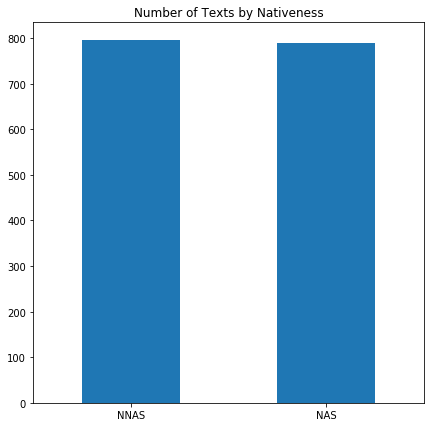

In [7]:
df.Nativeness.value_counts()
df.Nativeness.value_counts().plot.bar(figsize=(7,7), rot=0, title="Number of Texts by Nativeness")

When comparing native speaker text counts to non-native speaker text counts, the corpus is fairly balanced, with 795 non-native Arabic speaker texts to 790 native Arabic speaker texts. Let's break this down further by L1:

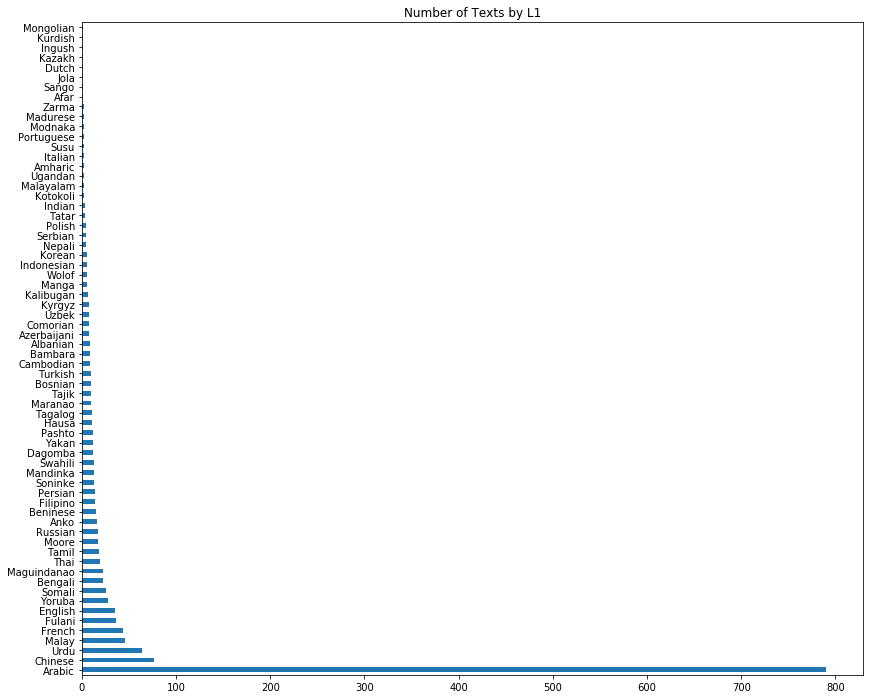

In [8]:
df.L1.value_counts().plot.barh(figsize=(14,12), title="Number of Texts by L1")

Maybe not the most appealing graph in the world, but it does illustrate the unbalanced makeup of the data clearly once the larger category of L1 is used to break things out. This may be worth addressing later by collapsing languages into families, but it may also not be worth the trouble if all we're trying to do is look at "Native Arabic MSA Learners" compared to "Non-Native Arabic MSA Learners". Otherwise, things have been going pretty smoothly so far... But uh oh, looks like we're maybe missing some titles, since the counts above (1,366 vs. 1,585) don't align with the rest of the table. It stands to reason that some participants neglected to give their responses a title (#TeacherProblems). Let's fix that by making them empty instead of NaN values so that they won't bother our tokenizer later.

### 2B. Filling in "NaN" Values in Titles <a name="NaN"></a>

In [9]:
df['Title'].fillna('',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1585 entries, S001_T1_M_Pre_NNAS_W_C to S942_T1_M_Uni_NAS_S_C
Data columns (total 13 columns):
Nativeness     1585 non-null object
L1             1585 non-null object
NumLangs       1585 non-null int64
Nationality    1585 non-null object
Age            1585 non-null object
Gender         1585 non-null object
YearsStudy     1585 non-null int64
GenLvl         1585 non-null object
LvlStdy        1585 non-null object
Title          1585 non-null object
Text           1585 non-null object
Genre          1585 non-null object
Mode           1585 non-null object
dtypes: int64(2), object(11)
memory usage: 173.4+ KB


Much better! And thankfully, the directionality of our text has been maintained in the transition from XML to a `DataFrame` and the texts themselves remain readable after being imported. This will hopefully remain the case when we  tokenize our text. Let's try that now using NLTK's `word_tokenize` function on both the titles and the texts.

### 2C. Tokenizing Texts and Titles <a name="TOK"></a>

In [10]:
df['TextToks'] = df.Text.map(nltk.word_tokenize)
df['TitleToks'] = df.Title.map(nltk.word_tokenize)
df['TextLen'] = df.TextToks.map(len)
df['TitleLen'] = df.TitleToks.map(len)
df.head()

,Nativeness,L1,NumLangs,Nationality,Age,Gender,YearsStudy,GenLvl,LvlStdy,Title,Text,Genre,Mode,TextToks,TitleToks,TextLen,TitleLen
DocID,,,,,,,,,,,,,,,,,
S001_T1_M_Pre_NNAS_W_C,NNAS,Moore,4,Burkina Faso,20,Male,14,Pre-university,Diploma course,الرحلة إلى القرية لزيارة ذوي القربى,اعتدت الذهاب إلى قريتي في الإجازات الصيفيّة ال...,Narrative,Written,"[اعتدت, الذهاب, إلى, قريتي, في, الإجازات, الصي...","[الرحلة, إلى, القرية, لزيارة, ذوي, القربى]",169,6
S001_T2_M_Pre_NNAS_W_C,NNAS,Moore,4,Burkina Faso,20,Male,14,Pre-university,Diploma course,الجمع بين العلم الشرعي والعلوم الدنيوية لحمزة ...,أحبّ أن ألتحق بكلِّية الشريعة بعد الانتها من ا...,Discussion,Written,"[أحبّ, أن, ألتحق, بكلِّية, الشريعة, بعد, الانت...","[الجمع, بين, العلم, الشرعي, والعلوم, الدنيوية,...",161,9
S002_T1_M_Pre_NNAS_W_C,NNAS,Russian,5,Russian,25,Male,5,Pre-university,Diploma course,رحلة الحج المباركة,كتب الله لي أن أحج إلى بيته الحرام السنة الماض...,Narrative,Written,"[كتب, الله, لي, أن, أحج, إلى, بيته, الحرام, ال...","[رحلة, الحج, المباركة]",317,3
S002_T2_M_Pre_NNAS_W_C,NNAS,Russian,5,Russian,25,Male,5,Pre-university,Diploma course,أكثر من التخصص,الحمد لله الذي وفقني لدراسة شرعية في جامعة الإ...,Discussion,Written,"[الحمد, لله, الذي, وفقني, لدراسة, شرعية, في, ج...","[أكثر, من, التخصص]",173,3
S003_T1_M_Pre_NNAS_W_C,NNAS,Tatar,4,Russian,24,Male,6,Pre-university,Diploma course,رحلتي إلى الجبال,في أحد الأيام الصيف أخبرنا أبي بسفرٍ إلى الغاب...,Narrative,Written,"[في, أحد, الأيام, الصيف, أخبرنا, أبي, بسفرٍ, إ...","[رحلتي, إلى, الجبال]",133,3


The texts themselves are tokenizing nicely just by using NLTK, ~although the titles seem to be giving an issue. I'll have to look into that later; for now, they're not crucial.~ Replacing 'NaN' values with an empty string did the trick here. Let's take a close look at the first tokenized passage just to make sure things look okay.

In [11]:
print(df.iloc[0].TextToks)

['اعتدت', 'الذهاب', 'إلى', 'قريتي', 'في', 'الإجازات', 'الصيفيّة', 'الموجودة', 'في', 'غرب', 'بلدي', 'المسمّى', 'ببوركينا', 'فاسو', '.', 'تُسَمّى', 'قريتي', 'ساغابتنفا،', 'قمت', 'برحلة', 'إليها', 'في', 'الإجازة', 'الصيفيّة', 'الماضية', 'وكانت', 'من', 'أمتع', 'الرّحلات', 'اللّتي', 'رحلت', 'إليها', 'وأفضلها،', 'فبعد', 'أن', 'قرّرت', 'الرّحيل', 'إليها،', 'اتصلت', 'بمن', 'فيها', 'من', 'سادة', 'القوم', 'وكبارهم،', 'فسُرّو', 'وفَرحو؛', 'لما', 'سمعو', 'منّي', 'ما', 'يسرّ', 'أفئدتهم', 'ولما', 'طال', 'الالتقاء', 'بيننا', 'لسبب', 'طلب', 'العلم', 'والسير', 'في', 'الأرض', 'لأجله', 'فاازددت', 'همّة', 'في', 'المسير', 'لما', 'سمعت', 'إقداماً', 'وحبّاً', 'لأهل', 'القرية', 'تجاهي', 'فخرجت', 'في', 'طريقي', 'الخامس', 'عشرة', 'من', 'رمضان', 'متّجها', 'إلى', 'القرية،', 'فوصلت', 'إليها', 'في', 'يومه،', 'فأكرموني', 'وطبوخو', 'لي', 'طعاما', 'شهيّاً', 'طاقت', 'إليه', 'قلبي', 'قبل', 'ذوقي', 'ثمّ', 'قدموني', 'إماما،', 'فصليت', 'بهم', 'الظّهر', 'وقِلت', 'بعدها', '.', 'فلما', 'استيقظت', 'للعصر', 'وصليت', 'جاؤوني', '

Uh oh, this might be a problem. Our tokenized words are still correctly printing, but are they in the right order? At a glacne it looks like they're not, since the first word to the immediate right of the bracket is not the first word of the actual paragraph. But on closer inspection...

In [12]:
print(df.iloc[0].TextToks[0])

اعتدت


We're good! Everything is in the right direction, the right order, and tokenized by word in a way that makes sense. This may not be the best way to tokenize Arabic text, since it isn't splitting the meaningful prefixes and suffixes away from the words that they attach to (e.g. object pronouns often attach to verbs in Arabic as suffixes), but it is readily available and easily refined at a later time. Let's move on and add a rough calculation of TTR (again, we can refine this later).

### 2D. Adding TTR <a name="TTR"></a>

In [13]:
def TTR_Calc(tokens):
    return len(set(tokens))/len(tokens)

df['TTR'] = df.TextToks.map(TTR_Calc)
df
df.info()

df.describe()

,Nativeness,L1,NumLangs,Nationality,Age,Gender,YearsStudy,GenLvl,LvlStdy,Title,Text,Genre,Mode,TextToks,TitleToks,TextLen,TitleLen,TTR
DocID,,,,,,,,,,,,,,,,,,
S001_T1_M_Pre_NNAS_W_C,NNAS,Moore,4,Burkina Faso,20,Male,14,Pre-university,Diploma course,الرحلة إلى القرية لزيارة ذوي القربى,اعتدت الذهاب إلى قريتي في الإجازات الصيفيّة ال...,Narrative,Written,"[اعتدت, الذهاب, إلى, قريتي, في, الإجازات, الصي...","[الرحلة, إلى, القرية, لزيارة, ذوي, القربى]",169,6,0.798817
S001_T2_M_Pre_NNAS_W_C,NNAS,Moore,4,Burkina Faso,20,Male,14,Pre-university,Diploma course,الجمع بين العلم الشرعي والعلوم الدنيوية لحمزة ...,أحبّ أن ألتحق بكلِّية الشريعة بعد الانتها من ا...,Discussion,Written,"[أحبّ, أن, ألتحق, بكلِّية, الشريعة, بعد, الانت...","[الجمع, بين, العلم, الشرعي, والعلوم, الدنيوية,...",161,9,0.844720
S002_T1_M_Pre_NNAS_W_C,NNAS,Russian,5,Russian,25,Male,5,Pre-university,Diploma course,رحلة الحج المباركة,كتب الله لي أن أحج إلى بيته الحرام السنة الماض...,Narrative,Written,"[كتب, الله, لي, أن, أحج, إلى, بيته, الحرام, ال...","[رحلة, الحج, المباركة]",317,3,0.637224
S002_T2_M_Pre_NNAS_W_C,NNAS,Russian,5,Russian,25,Male,5,Pre-university,Diploma course,أكثر من التخصص,الحمد لله الذي وفقني لدراسة شرعية في جامعة الإ...,Discussion,Written,"[الحمد, لله, الذي, وفقني, لدراسة, شرعية, في, ج...","[أكثر, من, التخصص]",173,3,0.757225
S003_T1_M_Pre_NNAS_W_C,NNAS,Tatar,4,Russian,24,Male,6,Pre-university,Diploma course,رحلتي إلى الجبال,في أحد الأيام الصيف أخبرنا أبي بسفرٍ إلى الغاب...,Narrative,Written,"[في, أحد, الأيام, الصيف, أخبرنا, أبي, بسفرٍ, إ...","[رحلتي, إلى, الجبال]",133,3,0.766917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S939_T1_F_Uni_NNAS_S_C,NNAS,Swahili,3,Comorian,23,Female,3,University,BA,قصة,أ- بسم الله الرحمن الرحيم\nالاسم #معلومة شخصية...,Narrative,Spoken,"[أ-, بسم, الله, الرحمن, الرحيم, الاسم, #, معلو...",[قصة],212,1,0.533019
S939_T2_F_Uni_NNAS_S_C,NNAS,Swahili,3,Comorian,23,Female,3,University,BA,التخصص,أ- بسم الله الرحمن الرحيم\nأ- أ ق أ أنا في الج...,Discussion,Spoken,"[أ-, بسم, الله, الرحمن, الرحيم, أ-, أ, ق, أ, أ...",[التخصص],48,1,0.625000
S940_T1_M_Pre_NNAS_S_C,NNAS,Yoruba,3,Nigerian,26,Male,8,Pre-university,Diploma course,التخصص,الحمد لله، والصلاة والسلام على أشرف المرسلين، ...,Discussion,Spoken,"[الحمد, لله،, والصلاة, والسلام, على, أشرف, الم...",[التخصص],296,1,0.587838


<class 'pandas.core.frame.DataFrame'>
Index: 1585 entries, S001_T1_M_Pre_NNAS_W_C to S942_T1_M_Uni_NAS_S_C
Data columns (total 18 columns):
Nativeness     1585 non-null object
L1             1585 non-null object
NumLangs       1585 non-null int64
Nationality    1585 non-null object
Age            1585 non-null object
Gender         1585 non-null object
YearsStudy     1585 non-null int64
GenLvl         1585 non-null object
LvlStdy        1585 non-null object
Title          1585 non-null object
Text           1585 non-null object
Genre          1585 non-null object
Mode           1585 non-null object
TextToks       1585 non-null object
TitleToks      1585 non-null object
TextLen        1585 non-null int64
TitleLen       1585 non-null int64
TTR            1585 non-null float64
dtypes: float64(1), int64(4), object(13)
memory usage: 235.3+ KB


,NumLangs,YearsStudy,TextLen,TitleLen,TTR
count,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000
mean,2.344479,2.400631,184.945741,2.959621,0.754451
std,1.269274,3.702528,238.092437,2.127474,0.093820
min,1.000000,0.000000,3.000000,0.000000,0.411670
25%,1.000000,0.000000,90.000000,2.000000,0.694805
50%,2.000000,0.000000,149.000000,3.000000,0.755245
75%,3.000000,3.000000,230.000000,4.000000,0.812500
max,10.000000,19.000000,7421.000000,24.000000,1.000000


### 2E. Collapsing L1 Data Into L1 Families <a name="L1FAM"></a>
The last thing I'm going to do here is collapse the L1 data into language families, since there are a number of languages with only one or two observations represented. The original L1 labels used are also perhaps not in keeping with the most accurate, respectful terms for these languages ("Moore" and "Ugandan" come to mind, as well as one named "Modnaka" which I am unfamiliar with and was unable to find through searching, including in Ethnologue). Additionally, since some of the members would have otherwise been on their own in their language family (SVC doesn't like this), I've elected to create an "Unclassified" category to hold members of language families with <5 observations. Arabic was also assigned to its own "family" here, since it constitutes such a large portion of the data already.

To this end, I consulted [ethnologue.com](www.ethnologue.com) for the language families to which the L1s represented here belong. In general, I've used the highest-level family name available in order to maximize the size of the groups, although in the case of Indo-European languages, I split them out into smaller subfamilies (Indo-Iranian, Balto-Slavic, Germanic, and Italic) to avoid lumping too many things together that might be more typologically dissimilar than not. The following code cell creates sets that contain the L1s as they are written in the dataframe and the one immediately after that creates a new column in the `DataFrame` called `L1family` that contains the name of the language's macro family. After this, we'll pickle our final `DataFrame` and call it a day for organization.

In [14]:
Austronesian = {"Malay","Maguindanao",'Kalibugan',"Yakan","Maranao",
               "Tagalog","Filipino","Madurese","Indonesian"}
Chadic = {"Anko","Hausa"}
Cushitic = {"Somali","Afar"}
Dravidian = {"Tamil","Malayalam"}
Germanic = {"English", "Dutch", "German"}
IndoIran = {"Persian", 'Bengali', 'Pashto','Tajik', 'Urdu',"Kurdish",
           "Nepali", "Hindi"}
Italic = {"French", "Italian", 'Portuguese'}
NigerCongo = {"Moore","Ugandan","Dagomba","Swahili","Yoruba", "Wolof",
             "Kotokoli", "Fulani", "Beninese", "Bambara", "Soninke",
             "Mandinka","Susu","Jola","Comorian"}
NiloSahar = {"Zarma", "Manga"}
BaltoSlavic = {"Russian", "Bosnian", "Serbian","Polish"}
Turkic = {"Tatar","Azerbaijani", "Turkish","Uzbek", "Kyrgyz","Kazakh"}

In [15]:
def l1_fam(x):
    if x['L1'] == "Arabic":
        return "Arabic"
    elif x['L1'] == "Albanian":
        return "Albanian"
    elif x['L1'] == "Cambodian":
        return "AustroAsiatic"
    elif x['L1'] == 'Korean':
        return "Koreanic"
    elif x['L1'] == "Thai":
        return "KraDai"
    elif x['L1'] == "Chinese":
        return "SinoTib"
    elif x['L1'] in Austronesian:
        return "Austronesian"
    elif x['L1'] in Chadic:
        return "Chadic"
    elif x['L1'] in Cushitic:
        return "Cushitic"
    elif x['L1'] in Dravidian:
        return "Dravidian"
    elif x['L1'] in Germanic:
        return "Germanic"
    elif x['L1'] in IndoIran:
        return "IndoIran"
    elif x['L1'] in Italic:
        return "Italic"
    elif x['L1'] in NigerCongo:
        return "NigerCongo"
    elif x['L1'] in NiloSahar:
        return "NiloSahar"
    elif x['L1'] in BaltoSlavic:
        return "BaltoSlavic"
    elif x['L1'] in Turkic:
        return "Turkic"
    else:
        return "Unclassified"
    
df['L1family'] = df.apply(lambda x: l1_fam(x), axis=1)

In [16]:
df['L1family'].value_counts()
sum(df['L1family'].value_counts())

Arabic           790
NigerCongo       176
Austronesian     128
IndoIran         127
SinoTib           76
Italic            48
Turkic            36
Germanic          36
BaltoSlavic       35
Cushitic          27
Chadic            27
Dravidian         20
KraDai            19
Unclassified      10
AustroAsiatic      9
Albanian           9
NiloSahar          7
Koreanic           5
Name: L1family, dtype: int64

1585

Definitely a step in the right direction. Let's try visualizing this split now the same way we did above using language family instead of language itself:

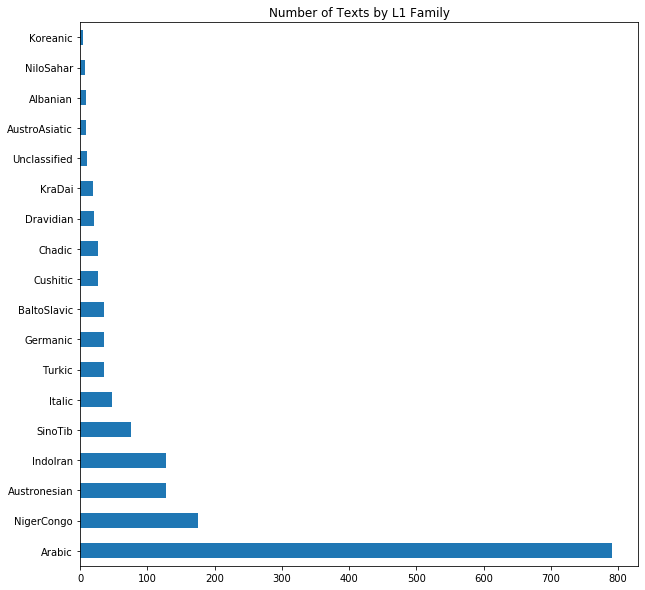

In [17]:
df.L1family.value_counts().plot.barh(figsize=(10,10), title="Number of Texts by L1 Family")

Looking a lot better! Let's go ahead and save our `DataFrame` as a pickle object and wrap up. Even if we don't end up using all of the information that we've added ourselves, this might be useful to have in the future for exploring other questions with this data set.

In [18]:
# Pickling our DataFrame for later use so that we don't need to recreate anything from
# scratch once we get around to analysis
pd.to_pickle(df, "ALC_df.pkl")

[Back to Top](#top)